In [ ]:
import environment.utils as utils
import numpy as np

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
market_price = 138/10000  # Example market price
T = 2.0  # Time to expiry (years)
K = 0.04259 - 100/10000  # Strike rate
R = 0.04259  # Forward swap rate

# Example OIS rates and maturities
maturities = [3, 4]  # Payment dates (years)
ois_rates = [0.03, 0.032]  # Corresponding OIS zero rates (3% and 3.2%)


S = 0.866+0.897-0.2

def black_price_swaption(sigma, T, K, S, R, option_type='payer'):
    """
    Black formula for European swaptions including the annuity factor.
    
    Parameters:
        sigma (float): Black implied volatility
        T (float): Time to expiration (years)
        K (float): Strike rate
        S (float): Present value of the fixed leg annuity
        R (float): Forward swap rate
        option_type (str): 'payer' or 'receiver'
    
    Returns:
        float: Black swaption price
    """
    if T == 0:
        return S * max(0, (R - K) if option_type == 'payer' else (K - R))
    
    d1 = (np.log(R / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'payer':
        price = S * (R * norm.cdf(d1) - K * norm.cdf(d2))
    else:  # Receiver swaption
        price = S * (K * norm.cdf(-d2) - R * norm.cdf(-d1))
    #print(sigma, price)
    return price

black_price = black_price_swaption(0.2, T, K, S, R, option_type='payer')

loss = black_price - market_price
print(loss)

0.003339365941290171


In [3]:
from scipy.stats import norm

# Given market data
F = 0.042  # 2y2y forward swap rate (4.2%)
K = 0.042  # Assume ATM strike at the forward swap rate
T = 2.0  # Time to expiry (2 years)
sigma_annualized = 0.2504  # ATM Black volatility (25% per annum)

# Convert annualized volatility to Black model usable volatility
sigma = sigma_annualized * np.sqrt(T)

# Black's formula for swaption pricing
def black_swaption_price(F, K, T, sigma, option_type="payer"):
    """ Computes Black's model price for a European swaption """
    if K <= 0:  # Strike must be positive
        return 0

    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "payer":
        price = F * norm.cdf(d1) - K * norm.cdf(d2)
    else:  # receiver swaption
        price = K * norm.cdf(-d2) - F * norm.cdf(-d1)
    
    return max(price, 0)  # Prices cannot be negative

# Compute ATM swaption prices
payer_swaption_price = black_swaption_price(F, K, T, sigma, "payer")
receiver_swaption_price = black_swaption_price(F, K, T, sigma, "receiver")

payer_swaption_price*10000, receiver_swaption_price*10000


(83.04322756162958, 83.04322756162955)

In [8]:
utils.Utils(init_ttm=30, np_seed=42, num_sim=1).get_sim_path_sabr()

NameError: name 'utils' is not defined

In [3]:
#load libraries
import math
import numpy as np
import warnings
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import cm



def load_object(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [4]:
path_params = os.path.join(os.getcwd(), "parameters")
forwards = load_object(path_params+"/spot_forwards.pkl")
s0_exp = load_object(path_params+"/vol_initial_correction.pkl")
epsilon_exp = load_object(path_params+"/volvol_initial_correction.pkl")
doust_fwd_fwd = load_object(path_params+"/fwdfwd_corr.pkl")
doust_vol_vol = load_object(path_params+"/volvol_corr.pkl")
corr_fwd_vol = load_object(path_params+"/fwdvol_corr.pkl")
params_g = load_object(path_params+"/vol_params_g.pkl")
params_h= load_object(path_params+"/volvol_params_h.pkl")
spots= load_object(path_params+"/spot_rates.pkl")

print(epsilon_exp)

[0.97689492 1.18658079 1.37688502 1.22795952 1.27988768 0.74868572
 0.78605051 0.85688928 0.88385214 0.83346144 0.84909792 0.70456868
 0.72118771 0.65380347 0.6718872  0.63298171 0.65168457 0.61453961
 0.63214282]


In [5]:
rho_mat = doust_fwd_fwd[:19, :19]
theta_mat = doust_vol_vol[:19, :19] #TODO: check if this is correct, or it should remove the first row and column instead
phi_mat = corr_fwd_vol
fwd_tenors = np.arange(1,10.5,0.5)

In [6]:
#reduce ranking
import numpy as np

def reduceRank(corr_matrix, no_of_factors):
    """
    Optimized function to reduce the correlation matrix rank 
    using the eigenvalue zeroing technique.
    """
    # Perform SVD
    Q, lambda_, Vt = np.linalg.svd(corr_matrix)

    # Construct the reduced-rank matrix
    H = np.diag(np.sqrt(lambda_[:no_of_factors]))
    B = Q[:, :no_of_factors] @ H
    reduced_cov_matrix = B @ B.T

    # Convert to correlation matrix efficiently
    std_devs = np.sqrt(np.diag(reduced_cov_matrix))
    reduced_corr_matrix = reduced_cov_matrix / np.outer(std_devs, std_devs)

    return B, reduced_corr_matrix


In [7]:
def drawRandomNumbers (no_of_factors , cholesky):
    '''
    Draw a set of random numbers.
    @var no_of_factors: number of factors that we want
    to employ.
    @var cholesky: Cholesky decomposition of the
    correlation matrix describing the correlation
    among the random variables to simulate.
    '''
    if no_of_factors > 1:
        rand = np.random.normal(size = no_of_factors)
        return cholesky.dot(rand)
    else:
        return np.random.normal ()


def get_instant_vol_func(tau , params):
    '''
    Return the instantaneous volatility ,
    computed in terms of the parametric
    form proposed by Rebonato , at a given time t.
    @var t: time at which we want to compute the
    instantaneous volatility (in years)
    @var expiry: caplet expiry (in years)
    @var a: parameter a of Rebonato ’s instant. vol. function
    @var b: parameter b of Rebonato ’s instant. vol. function
    @var c: parameter c of Rebonato ’s instant. vol. function
    @var d: parameter d of Rebonato ’s instant. vol. function
    
    #g(T - t) & h(T - t)
    '''
    tau = np.maximum(tau, 0)
    a,b,c,d = params
    instantaneous_vol = (a + b * tau) * np.exp(-c * tau) + d
    return instantaneous_vol


from functools import partial
from scipy import interpolate, stats, integrate, optimize




In [8]:

path = os.path.join(os.getcwd(), "raw_dataset")
cap_df = pd.read_excel(path+"/caplet_raw.xlsx", sheet_name = 2, header = 0)
raw_spot_df = pd.read_csv(path+"/spot.csv")
raw_spot_df["Tenor"] = np.array([1/12, 2/12, 3/12, 0.5, 0.75, 1, 2, 3, 4, 5, 7, 9, 10, 12, 15, 20, 30, 50])

In [101]:
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

class ForwardCurveInterpolator:
    """
    A class for interpolating forward curves and calculating swap rates.
    
    This class provides tools to:
    1. Create interpolated forward curves from canonical points
    2. Calculate swap rates for different tenors and starting points
    3. Visualize forward curves and swap rates
    """
    
    def __init__(self, forward_rates, spot_rate=None, tau=0.5, resolution=2):
        """
        Initialize the forward curve interpolator.
        
        Parameters:
        -----------
        forward_rates : array-like
            The forward rates to interpolate (as decimals, not percentages).
        spot_rate : float, optional
            The spot rate (as a decimal). If None, uses the first value in forward_rates.
        tau : float, default=0.5
            The time increment between canonical forward rates (typically 0.5 for semiannual).
        resolution : int, default=2
            The resolution factor for the interpolation. For example, resolution=2 with tau=0.5
            gives points at 0, 0.25, 0.5, 0.75, etc.
        """
        self.tau = tau
        self.resolution = resolution
        self.forward_rates = np.asarray(forward_rates)
        self.spot_rate = spot_rate if spot_rate is not None else self.forward_rates[0]
        
        # Initialize the internal state
        self._setup_time_indexing()
        self._create_forward_curve()
        self._construct_dataframe()
        self._interpolate_forward_rates()
        self._create_forward_funcs()
        
    def _setup_time_indexing(self):
        """Set up the time indexing for different frequencies."""
        # Create canonical tenors with tau intervals
        self.max_tenor = len(self.forward_rates) * self.tau
        self.canon_tenors = np.arange(1, len(self.forward_rates) + 1) * self.tau
        
        # Tenors with tau intervals, starting from 0
        self.zcb_dates = np.concatenate(([0], self.canon_tenors))
        
        # Indices for forward rates
        self.fwd_start_indices = (self.zcb_dates[:-1] * self.resolution).astype(int)
        
        # All tenors with resolution * tau intervals
        self.all_tenors = np.linspace(0, self.max_tenor, int(self.max_tenor * self.resolution) + 1)
    
    def _create_forward_curve(self):
        """Create the forward curve and zero-coupon bond prices."""
        # Create full forward curve starting from spot rate
        self.fwd_w_spot = np.concatenate(([self.spot_rate], self.forward_rates))
        
        # Create zero-coupon bond prices from forward rates
        discount_factors = 1 / (1 + self.fwd_w_spot * self.tau)
        self.zcb_from_fwd = np.concatenate(([1], np.cumprod(discount_factors)))
        print(len(self.zcb_from_fwd), len(self.zcb_dates))
        
        # Interpolate to get zcb prices at all tenors
        zcb_cs = interpolate.CubicSpline(self.zcb_dates, self.zcb_from_fwd)
        self.zcb_all = zcb_cs(self.all_tenors)
    
    def _construct_dataframe(self):
        """Construct dataframe with tenors, ZCB, and forward rates."""
        self.df = pd.DataFrame({'Tenor': self.all_tenors, 'zcb': self.zcb_all, 'Forward': np.nan})
        self.df.loc[self.fwd_start_indices, 'Forward'] = self.fwd_w_spot
        
        # Add column with forward indices
        self.df['Forward Index'] = np.arange(len(self.df)) // self.resolution
    
    def _get_indices(self, s):
        """Get the indices for interpolation."""
        i_s = self.df.index[(self.df['Tenor'] <= s) & (self.df['Forward'].isna() == False)].max()
        i_s_p1 = self.df.index[(s < self.df['Tenor']) & (self.df['Forward'].isna() == False)].min()
        return i_s, i_s_p1
    
    def _get_gamma(self, s):
        """Calculate the gamma factor for interpolation."""
        i_s, i_s_p1 = self._get_indices(s)
        
        # Get the closest canonical forward rate before s
        f_is = self.df.loc[i_s, 'Forward']
        
        # Calculate f_s, the forward from s to i_s_p1
        p_0_s = self.df.loc[np.isclose(self.df['Tenor'], s, atol=1e-4), 'zcb'].values[0]
        p_0_isp1 = self.df.loc[i_s_p1, 'zcb']
        mod_accrual_factor = self.df.loc[i_s_p1, 'Tenor'] - s
        
        # Calculate the forward rate
        f_s = ((p_0_s/p_0_isp1) - 1) / mod_accrual_factor
        
        gamma = f_s / f_is
        
        return gamma, mod_accrual_factor
    
    def _interpolate_forward_rates(self):
        """Interpolate the forward rates."""
        s_values = self.df['Tenor'][:-3]
        gamma_list = [self._get_gamma(s)[0] for s in s_values]
        
        self.df.loc[s_values.index, 'gamma'] = gamma_list
        self.df['annuity_factor'] = self.tau
        
        # Add the i_s index to the gamma values
        i_s_list = [self._get_indices(s)[0] for s in s_values]
        self.df.loc[s_values.index, 'i_s'] = np.array(i_s_list, dtype=int)
    
    def _get_semiannual_tenors_relative(self, start, tenor):
        """Get periodic tenors relative to the start tenor."""
        end = start + tenor
        return np.arange(start + self.tau, end + 1e-8, self.tau)
    
    def _float_safe_mask(self, df_tenors, target_tenors, atol=1e-8):
        """Create a mask for selecting tenors safely with floating point comparison."""
        mask = np.zeros_like(df_tenors, dtype=bool)
        for t in target_tenors:
            mask |= np.isclose(df_tenors, t, atol=atol)
        return mask
    
    def _swap_weights(self, start, tenor=2):
        """Calculate swap weights."""
        # Get cash flow times relative to swap start
        semi_tenors = self._get_semiannual_tenors_relative(start, tenor)
        
        # Filter to only those tenor points in the DataFrame
        mask = self._float_safe_mask(self.df["Tenor"].values, semi_tenors)
        
        # Pull corresponding zero-coupon prices and annuity weights
        zcb = self.df.loc[mask, 'zcb']
        af = self.df.loc[mask, 'annuity_factor']
        
        # Compute swap annuity and weights
        annuity = (zcb * af).sum()
        weights = (zcb * af) / annuity
        
        # Assert normalization
        assert np.isclose(weights.sum(), 1), f"Swap weights do not sum to 1, it is {weights.sum()}"
        
        return weights
    
    def _create_forward_funcs(self):
        """Create forward rate functions for all valid tenors."""
        # Get all tenor values
        all_tenors = self.df['Tenor'].values
        
        # Precompute gamma values for all tenors
        gamma_dict = {}
        for t in np.unique(np.concatenate([all_tenors, all_tenors + self.tau])):
            mask = np.isclose(self.df['Tenor'].values, t, atol=1e-4)
            if any(mask):
                gamma_dict[t] = self.df.loc[mask, 'gamma'].iloc[0]
        
        # Determine valid tenors (skip last few indices)
        max_valid_tenor = all_tenors[-4]
        valid_tenors = [t for t in all_tenors if t + self.tau <= max_valid_tenor]
        
        # Factory function to create closure with proper variable binding
        def create_forward_func(s):
            # Precompute static quantities
            tau = self.tau
            e = s + tau
            
            # Get nearest tenor indices for s and e
            i_s, i_s_p1 = self._get_indices(s)
            i_e, i_e_p1 = self._get_indices(e)
            
            # Get actual tenor times
            T_i_s_p1 = self.df.loc[i_s_p1, 'Tenor']
            T_i_e_p1 = self.df.loc[i_e_p1, 'Tenor']
            
            # Get gamma values from precomputed dict
            gamma_s = gamma_dict.get(s)
            gamma_e = gamma_dict.get(e)
            
            # Theta values (constant)
            theta_s = T_i_s_p1 - s
            theta_e = T_i_e_p1 - e
            
            # Indices for canonical rate product
            rate_indices = self.df.loc[i_s_p1:i_e, 'Forward'].dropna().index
            
            def forward_func_timestep(forward_rates: np.ndarray) -> float:
                f_is_t = forward_rates[i_s]
                f_ie_t = forward_rates[i_e]
                
                f_s = f_is_t * gamma_s
                f_e = f_ie_t * gamma_e
                
                rates = forward_rates[rate_indices]
                
                canon_rates = np.prod(1/(1 + rates * tau))
                
                p_s_e = (1 + f_e * theta_e) / (1 + f_s * theta_s) * canon_rates
                
                f_interp_2 = (1 / p_s_e - 1) / tau
                return f_interp_2
            
            return forward_func_timestep
        
        # Create forward functions for each valid tenor
        self.forward_funcs = [create_forward_func(s) for s in valid_tenors]
        self.valid_tenors = valid_tenors
    
    def get_interpolated_forwards(self, tenors=None):
        """
        Get interpolated forward rates for specified tenors.
        
        Parameters:
        -----------
        tenors : array-like, optional
            The tenors at which to get the interpolated forward rates.
            If None, returns the interpolated forward rates for all valid tenors.
            
        Returns:
        --------
        tuple
            (tenors, interpolated_forward_rates)
        """
        if tenors is None:
            tenors = self.valid_tenors
        else:
            tenors = np.asarray(tenors)
            # Ensure tenors are within valid range
            tenors = tenors[tenors <= self.valid_tenors[-1]]
        
        # For each tenor, find the closest valid tenor and use its forward function
        interpolated_forwards = np.zeros_like(tenors, dtype=float)
        for i, t in enumerate(tenors):
            if t in self.valid_tenors:
                idx = self.valid_tenors.index(t)
                interpolated_forwards[i] = self.forward_funcs[idx](self.df['Forward'])
            elif t < self.valid_tenors[0]:
                interpolated_forwards[i] = self.df.loc[0, 'Forward']
            else:
                # Find the closest valid tenor
                idx = np.abs(np.array(self.valid_tenors) - t).argmin()
                interpolated_forwards[i] = self.forward_funcs[idx](self.df['Forward'])
        
        return tenors, interpolated_forwards
    
    def get_swap_rate(self, start_tenor, swap_tenor=2):
        """
        Calculate the swap rate starting at start_tenor with a duration of swap_tenor.
        
        Parameters:
        -----------
        start_tenor : float
            The starting tenor for the swap.
        swap_tenor : float, default=2
            The duration of the swap in years.
            
        Returns:
        --------
        float
            The swap rate.
        """
        ws = self._swap_weights(start_tenor, swap_tenor)
        
        semi_tenors = self._get_semiannual_tenors_relative(start_tenor, swap_tenor)
        mask = self._float_safe_mask(self.df["Tenor"].values, semi_tenors - self.tau)
        tenors = self.df.loc[mask, 'Tenor']
        
        # Get the interpolated forward rates for each tenor
        forward_indices = []
        for t in tenors:
            if t in self.valid_tenors:
                forward_indices.append(self.valid_tenors.index(t))
            else:
                # Find closest valid tenor
                idx = np.abs(np.array(self.valid_tenors) - t).argmin()
                forward_indices.append(idx)
        
        fwd_interp = np.array([self.forward_funcs[i](self.df['Forward']) for i in forward_indices])
        
        return (ws.values * fwd_interp).sum()
    
    def get_all_swap_rates(self, swap_tenor=2):
        """
        Calculate swap rates for all valid starting tenors.
        
        Parameters:
        -----------
        swap_tenor : float, default=2
            The duration of the swap in years.
            
        Returns:
        --------
        tuple
            (starting_tenors, swap_rates)
        """
        # Ensure we don't try to start swaps too close to the end
        max_start = self.max_tenor - swap_tenor - self.tau
        starts = self.df['Tenor'][self.df['Tenor'] <= max_start].values
        
        swap_rates = [self.get_swap_rate(start, swap_tenor) for start in starts]
        
        return starts, swap_rates
    
    def plot_curves(self, figsize=(10, 6), include_swaps=True, swap_tenor=2):
        """
        Plot the original and interpolated forward curves, and optionally the swap rates.
        
        Parameters:
        -----------
        figsize : tuple, default=(10, 6)
            The figure size.
        include_swaps : bool, default=True
            Whether to include swap rates in the plot.
        swap_tenor : float, default=2
            The duration of the swap in years, used only if include_swaps is True.
            
        Returns:
        --------
        matplotlib.figure.Figure
            The figure object.
        """
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot original forward rates
        forward_tenors = self.df['Tenor'].loc[self.df['Forward'].dropna().index]
        ax.plot(forward_tenors, self.df['Forward'].dropna(), 'o-', label='Original Forward Rates')
        
        # Plot interpolated forward rates
        tenors, interp_forwards = self.get_interpolated_forwards()
        ax.plot(tenors, interp_forwards, 'o-', label='Interpolated Forward Rates')
        
        # Plot swap rates if requested
        if include_swaps:
            starts, swap_rates = self.get_all_swap_rates(swap_tenor)
            ax.plot(starts, swap_rates, 'o-', label=f'{swap_tenor}-Year Swap Rates')
        
        # Configure plot
        ax.set_xlabel('Tenor (years)')
        ax.set_ylabel('Rate')
        ax.set_title('Forward and Swap Rates')
        ax.legend()
        ax.grid(True)
        
        # Set x-axis ticks to be more intuitive
        max_tenor = np.ceil(self.max_tenor)
        ax.set_xticks(np.arange(0, max_tenor + 1, 1))
        
        plt.tight_layout()
        return fig
    
import numpy as np

# Create sample forward rates (as decimals, not percentages)
forward_rates = np.linspace(0.01, 0.05, 20)  # 20 forward rates from 1% to 5%
spot_rate = 0.008  # 0.8%

# Initialize the interpolator with custom parameters
interpolator = ForwardCurveInterpolator(
    forward_rates=forward_rates,
    spot_rate=spot_rate,
    tau=0.5,          # Default 0.5 (semiannual)
    resolution=2      # Default 2 (0, 0.25, 0.5, 0.75, etc. with tau=0.5)
)

# Get interpolated forward rates
tenors, interp_forwards = interpolator.get_interpolated_forwards()

# Calculate swap rates for a specific starting point
start_tenor = 1.0    # 1 year
swap_tenor = 2.0     # 2-year swap
swap_rate = interpolator.get_swap_rate(start_tenor, swap_tenor)
print(f"2-year swap rate starting at year 1: {swap_rate:.4%}")

# Calculate all valid swap rates
starts, swap_rates = interpolator.get_all_swap_rates(swap_tenor=2)

# Visualize the curves
fig = interpolator.plot_curves(include_swaps=True, swap_tenor=2)
plt.show()

22 21


ValueError: The length of `y` along `axis`=0 doesn't match the length of `x`

36
TENORLEN: 36
0.0 0
0.25 1
0.5 2
0.75 3
1.0 4
1.25 5
1.5 6
1.75 7
2.0 8
2.25 9
2.5 10
2.75 11
3.0 12
3.25 13
3.5 14
3.75 15
4.0 16
4.25 17
4.5 18
4.75 19
5.0 20
5.25 21
5.5 22
5.75 23
6.0 24
6.25 25
6.5 26
6.75 27
7.0 28
7.25 29
7.5 30
7.75 31
8.0 32
8.25 33
8.5 34
8.75 35


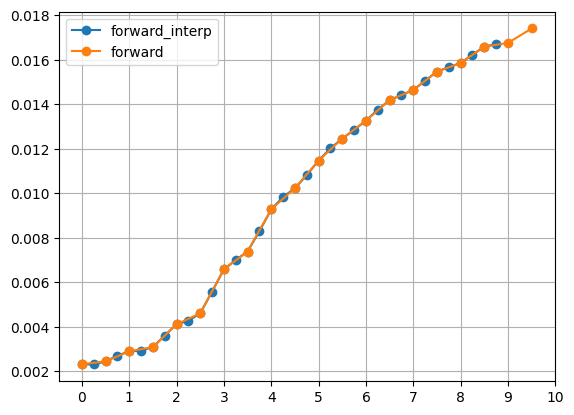

In [102]:


def create_interp_tenors(tau, resolution, f_0):
    num_forwards = len(f_0)
    canon_short_idx = np.arange(num_forwards) * tau  # [0.0, 0.5, 1.0, ...]
    dt = tau / resolution
    # Time grid
    T_max = tenor_grid[-1]
    
    time_grid = np.arange(0, T_max + dt, dt)  # [0.0, 0.25, ..., T_max]


    






# =============================================================================
#                               TIME INDEXING
# =============================================================================
# create tenors with semiannual (0.5) intervals, starting from 0 ending at 10 (years)
canon_short_idx = np.arange(1, 21)*0.5

# tenors with semiannual (0.5) intervals, starting from 0 ending at 10 (years)
zcb_dates_semiannual = np.concatenate(([0],canon_short_idx)) # used for zcb and fwd rates

# remove last index as the tenor is pointing to the start of the forward rates
fwd_start_dates_monthly = (zcb_dates_semiannual[:-1] * 4).astype(int) 

# tenors with monthly (1/12) intervals, starting from 0 ending at 10 (years)
tenors_all_monthly = np.linspace(0, 10, 121)
#print(tenors_all_monthly)
tenors_all_quarterly = np.linspace(0, 10, 41)
tenors_all_monthly = tenors_all_quarterly
#print(tenors_all_quarterly)
# =============================================================================




# =============================================================================
#           Create the forard curve starting from the spot rate
# =============================================================================
# create full 6m LIBOR forward curve starting from spot rate
libor_6m_spot = raw_spot_df.loc[raw_spot_df["Tenor"] == 0.5, "Spot"].iloc[0] / 100
forwards = np.array(cap_df["Reset Rate"]/100)
fwd_w_spot = np.concatenate(([libor_6m_spot], forwards))

#fwd_w_spot = np.arange(len(fwd_w_spot))/len(fwd_w_spot)/100 + 0.01


# create zcb from the forward rates
discount_factors = 1 / (1 + fwd_w_spot * 0.5)
zcb_from_fwd = np.concatenate(([1], np.cumprod(discount_factors)))

# interpolate to monthly values
zcb_cs = interpolate.CubicSpline(zcb_dates_semiannual, zcb_from_fwd)
zcb_monthly = zcb_cs(tenors_all_monthly)
# =============================================================================




# =============================================================================
#          Construct dataframe with tenors, zcb and forward rates
# =============================================================================
df = pd.DataFrame({'Tenor': tenors_all_monthly, 'zcb': zcb_monthly, 'Forward': np.nan})
df.loc[fwd_start_dates_monthly, 'Forward'] = fwd_w_spot
# add column with backfilled forward indices, such that the value in this column is 0 from 0 to 5, 1 from 6 to 11, 2 from 12 to 17, etc.    
df['Forward Index'] = np.arange(len(df)) // 6

# =============================================================================





# =============================================================================
#                       Interpolate the forward rates
# =============================================================================
def get_indices(s, df):
    i_s = df.index[(df['Tenor'] <= s) & (df['Forward'].isna() == False)].max()
    i_s_p1 = df.index[(s < df['Tenor']) & (df['Forward'].isna() == False)].min()
    return i_s, i_s_p1

def get_gamma(s, df):


    i_s, i_s_p1 = get_indices(s, df)
    # get the closest canonical forward rate before s 
    f_is = df.loc[i_s, 'Forward']
    
    # Calculate f_s, the forward from s to i_s_p1. gets shorter as s approaches i_s_p1
    p_0_s = df.loc[np.isclose(df['Tenor'], s, atol=1e-4), 'zcb'].values[0]
    # get the zcb price 
    p_0_isp1 = df.loc[i_s_p1, 'zcb']
    mod_accrual_factor = df.loc[i_s_p1, 'Tenor'] - s
    # p(0,s,sp1) = p(0,sp1)/p(0,s)
    # isp1 is a higher forward rate, therefore the zcb price is lower, which makes f_s higher
    f_s = ((p_0_s/p_0_isp1) - 1) / mod_accrual_factor
    
    gamma =  f_s/ f_is


    return gamma, mod_accrual_factor

def add_interp_rates(df):
    """calculates the interpolated rates for a list of tenors s_list and adds them to the supplied dataframe"""
    s_values = df['Tenor'][:-3]
    gamma_list = [get_gamma(s, df)[0] for s in s_values]
    annuity_factor_list = [get_gamma(s, df)[1] for s in s_values]

    df.loc[s_values.index, 'gamma'] = gamma_list 
    df['annuity_factor'] = 0.5
    #df.loc[s_values.index, 'annuity_factor'] = annuity_factor_list
    # add the f_is index to the gamma values
    # we start by finding i_s for each s
    i_s_list = [get_indices(s, df)[0] for s in s_values]    
    df.loc[s_values.index, 'i_s'] = np.array(i_s_list, dtype=int).astype(int)
    return df



df = add_interp_rates(df)
# =================================================================



# =============================================================================
#                         create swap rate weights
# =============================================================================
def get_semiannual_tenors_relative(start, tenor):
    end = start + tenor
    # Start at start + 0.5, step by 0.5, go up to and including end
    return np.arange(start + 0.5, end + 1e-8, 0.5)

def float_safe_mask(df_tenors, target_tenors, atol=1e-8):
    mask = np.zeros_like(df_tenors, dtype=bool)
    for t in target_tenors:
        mask |= np.isclose(df_tenors, t, atol=atol)
    return mask


def swap_weights(start, df, tenor=2):
    # Compute end of swap

    # Get semiannual cash flow times relative to swap start
    semi_tenors = get_semiannual_tenors_relative(start, tenor)
    #print(f"start: {start}, end: {semi_tenors[-1]}")
    #print(f"start of swap: {start}")
    #print(f"weight tenors (should be 0.5 ahead of forward rate tenors): {semi_tenors=}")
    # Filter to only those tenor points in the DataFrame
    mask = float_safe_mask(df["Tenor"].values, semi_tenors)
    #print(mask, df.loc[mask, 'Tenor'])

    
    # Pull corresponding zero-coupon prices and annuity weights
    zcb = df.loc[mask, 'zcb']
    af = df.loc[mask, 'annuity_factor']  # e.g., accrual fractions (usually 0.5)
    # Compute swap annuity and weights
    annuity = (zcb * af).sum()
    weights = (zcb * af) / annuity
    # Assert normalization
    assert np.isclose(weights.sum(), 1), "Swap weights do not sum to 1, its is {}".format(weights.sum())

    return weights




def get_swap_rate (start, df, interp_funcs, tenor=2):
    ws = swap_weights(start, df, tenor)

    rates_idx = df.loc[ws.index, 'i_s'].dropna().astype(int)

    index_actual = ws.index
    index_is = rates_idx.values
    #print("index_actual",index_actual.values)
    #print("index_is",index_is)
    semi_tenors = get_semiannual_tenors_relative(start, tenor)
    mask = float_safe_mask(df["Tenor"].values, semi_tenors-0.5)
    tenors = df.loc[mask, 'Tenor']
    #print(f"Forward rate tenors (s in f(0,s,t)): {tenors.values}")
    
    # gamma gets us from s to i_sp1
 
    #print(fwd_interp)
    fwd_interp = np.array([interp_funcs[i](df['Forward']) for i in tenors])
    #print(f"Forward rates: {fwd_interp}")
    #print(f"Swap weights: {ws.values}")

    return (ws.values * fwd_interp).sum()

#def get_frozon_Ws()

def get_all_swaps(df,interp_funcs, tenor=2):
    starts = df['Tenor'][:-(tenor*12*2)].values
    
    #print(starts)
    swap_rates = [get_swap_rate(start, df, interp_funcs, tenor) for start in starts]
    #plt.plot(starts+1, swap_rates)
    #plt.plot(df['Tenor'].loc[df['Forward'].dropna().index],df['Forward'].dropna())
    return swap_rates, starts
 


def create_all_tenor_forward_funcs(df, tenor=0.5):
    """
    Creates forward rate functions for all valid tenors in df.
    
    Parameters:
    df (pd.DataFrame): DataFrame with 'Tenor', 'Forward', 'gamma' columns
    tenor (float): Forward tenor period (default 0.5)
    
    Returns:
    dict: Dictionary mapping starting tenors to forward rate functions
    """
    # Get all tenor values
    all_tenors = df['Tenor'].values
    
    # Precompute gamma values for all tenors (do this once)
    gamma_dict = {}
    for t in np.unique(np.concatenate([all_tenors, all_tenors + tenor])):
        mask = np.isclose(df['Tenor'].values, t, atol=1e-4)
        if any(mask):
            gamma_dict[t] = df.loc[mask, 'gamma'].iloc[0]
    
    # Determine valid tenors (skip last 7 indices)
    max_valid_tenor = all_tenors[-4]
    valid_tenors = [t for t in all_tenors if t + tenor <= max_valid_tenor]
    # Factory function to create closure with proper variable binding
    def create_forward_func(s):
        # Precompute static quantities
        tau = tenor
        e = s + tau
        
        # Get nearest tenor indices for s and e
        i_s, i_s_p1 = get_indices(s, df)
        i_e, i_e_p1 = get_indices(e, df)
        
        # Get actual tenor times
        T_i_s_p1 = df.loc[i_s_p1, 'Tenor']
        T_i_e_p1 = df.loc[i_e_p1, 'Tenor']
        
        # Get gamma values from precomputed dict
        gamma_s = gamma_dict.get(s)
        gamma_e = gamma_dict.get(e)
        
        # Theta values (constant)
        theta_s = T_i_s_p1 - s
        theta_e = T_i_e_p1 - e
        
        # Indices for canonical rate product
        rate_indices = df.loc[i_s_p1:i_e, 'Forward'].dropna().index
        
        def forward_func_timestep(forward_rates: np.ndarray) -> float:
            forward_rates = forward_rates
            f_is_t = forward_rates[i_s]
            f_ie_t = forward_rates[i_e]
            
            f_s = f_is_t * gamma_s
            f_e = f_ie_t * gamma_e
            
            rates = forward_rates[rate_indices]
            
            canon_rates = np.prod(1/(1 + rates * tau))
            
            p_s_e = (1 + f_e * theta_e) / (1 + f_s * theta_s) * canon_rates

            f_interp_2 = (1 / p_s_e - 1) / tau 
            return f_interp_2
        
        return forward_func_timestep
    
    # Create forward functions for each valid tenor
    forward_funcs = [create_forward_func(s) for s in valid_tenors]
    
    return forward_funcs
all_forwards = create_all_tenor_forward_funcs(df)
print(len(all_forwards))

#sr = get_swap_rate(3/12, df, all_forwards)

#srs, starts = get_all_swaps(df, all_forwards, 2)  
#print((starts*2+2)/2)
#print(starts+1)
offset = 5
time = df['Tenor'].iloc[:-offset]
forward_curve = np.zeros(len(time))
print("TENORLEN:",len(time))
for t, canon_short_idx in enumerate(time):
    print(canon_short_idx,t)
    if canon_short_idx < 9.:
        forward_curve[t] = all_forwards[t](df['Forward'])
plt.plot(time, forward_curve,'o-', label='forward_interp')
plt.plot(df['Tenor'].loc[df['Forward'].dropna().index],df['Forward'].dropna(), 'o-', label='forward')
#plt.plot(starts+(2-0.5)/2, srs, '-', label='swap_interp', color='red')
# make grid for 0, 1, 2...10 years on the x axis
x = np.arange(0, 10.1, 1)
plt.legend()
plt.xticks(x)
plt.grid()


In [113]:
len(all_forwards)

36

In [115]:
9*4

36

In [112]:
#sr = get_all_swaps(df, all_forwards, 2)
fwds = df['Forward'].values
for t in range(4000):
    for forward in all_forwards:
        forward(fwds)


In [90]:
df

,Tenor,zcb,Forward,Forward Index,gamma,annuity_factor,i_s
0,0.00,1.000000,0.002318,0,1.000000,0.5,0.0
1,0.25,0.999410,NaN,0,0.980943,0.5,0.0
2,0.50,0.998842,0.002445,0,1.000000,0.5,2.0
3,0.75,0.998259,NaN,0,1.043539,0.5,2.0
4,1.00,0.997623,0.002898,0,1.000000,0.5,4.0
5,1.25,0.996913,NaN,0,1.016732,0.5,4.0
6,1.50,0.996179,0.003086,1,1.000000,0.5,6.0
7,1.75,0.995455,NaN,1,1.056449,0.5,6.0
8,2.00,0.994644,0.004112,1,1.000000,0.5,8.0
9,2.25,0.993663,NaN,1,1.037838,0.5,8.0


dt=0.25
times per year = 1.0


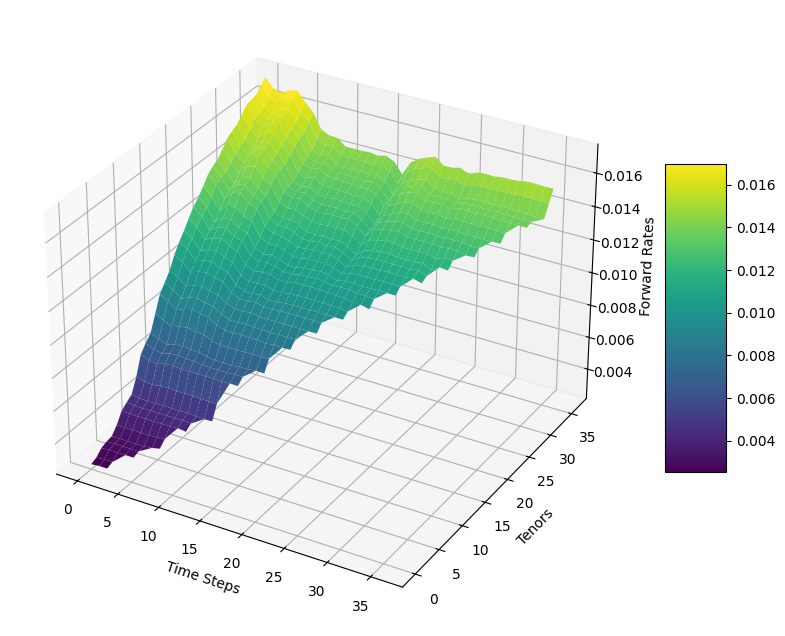

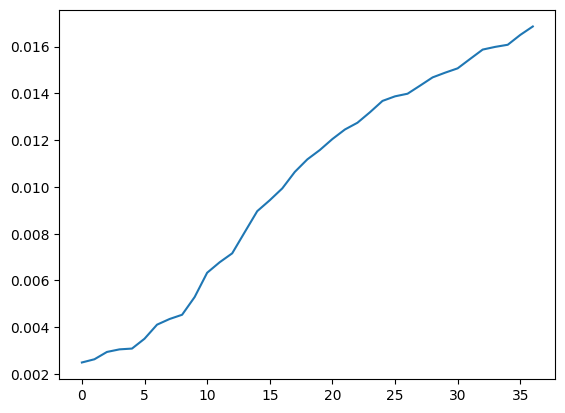

In [172]:


class LMMSABR():
    def __init__(self, rho_mat, theta_mat, phi_mat, g_params, h_params, epsilon_exp, s0_exp, yell=True):
        self.rho_mat = rho_mat
        self.theta_mat = theta_mat
        self.phi_mat = phi_mat
        self.g = partial(get_instant_vol_func, params=g_params)
        self.h = partial(get_instant_vol_func, params=h_params)
        self.epsilon_exp = epsilon_exp
        self.s0_exp = s0_exp
        if yell:
            print("h SHOULD PERHAPS BE FORCED TO BE POSITIVE")
    
    @staticmethod
    def getInstantaneousVolatility(t, expiry , params):
        '''
        Return the instantaneous volatility ,
        computed in terms of the parametric
        form proposed by Rebonato , at a given time t.
        @var t: time at which we want to compute the
        instantaneous volatility (in years)
        @var expiry: caplet expiry (in years)
        @var a: parameter a of Rebonato ’s instant. vol. function
        @var b: parameter b of Rebonato ’s instant. vol. function
        @var c: parameter c of Rebonato ’s instant. vol. function
        @var d: parameter d of Rebonato ’s instant. vol. function
        
        #g(T - t) & h(T - t)
        '''
        a,b,c,d = params
        tau = expiry - t
        instantaneous_vol = (a + b * tau) * np.exp(-c * tau) + d
        return instantaneous_vol
    

    def zcb_price(self, t, T,S, forwards):
        pass

    def get_fwd_drift(self, t, f_t: np.ndarray):
        """find the drift of the forward rate given all longer maturity forwards"""
        pass
    def get_vol_drift(self, t, f_t):
        pass

    def simulate(self, f_0, tenors, num_sim, tau):
        self.tenors = tenors
        self.num_sim = num_sim


        
        # so, we have 20 rates, and 1000 simulations, we must fill in the spot rates for each simulation. the spot rate for each simulation is f_sim[i,i] and so on, if we simulate months, the 6m forward is f_sim[i,i+6]
        # the number of steps must be a multiple of the number of tenors
        # since the intermediate rates (t + all_tenor)% len(tenors) != 0, depend on the previous rate, we point to the previous canon rate, using the function all_forwards[tenor](f_sim[i])





        # =============================================================================

        tau = 0.5
        resolution = 4 * tau
        num_forwards = len(f_0) # including L(0,0,tau)



        dt = tau / resolution
        print(f"{dt=}")
        print(f"times per year = {resolution*tau}")
        dt_sqrt = math.sqrt(dt)
        steps_per_year  = resolution * tau



        # Tenor grid
        tenor_grid = np.arange(num_forwards) * tau  # [0.0, 0.5, 1.0, ...]
        canon_indices = (tenor_grid*resolution/tau).astype(int) # indices of the simulated forward rates 

        # Time grid
        T_max = tenor_grid[-1]
        canon_rev_short_indices = np.arange(len(tenor_grid))[::-1] # reverse index of the forward rates [19, 18, 17, ...]
        
        time_grid = np.arange(0, T_max + dt, dt)  # [0.0, 0.25, ..., T_max]
        self.time_grid = time_grid
        non_canon_indices = np.arange(len(time_grid)) 
        all_fwd_indices = np.arange(len(time_grid)) # all forward rates indices
        # remove non-canon
        non_canon_indices = non_canon_indices[~np.isin(non_canon_indices, canon_indices)]
        assert time_grid[-1] == T_max, "Time grid does not end at the beginning of the last forward"
        
        ttm_mat = time_grid[None,:]-time_grid[:,None] # each row is a time increment, and each column represents the time to maturity of a forward rate
        num_sim = ttm_mat.shape[0]-1
        self.num_sim = num_sim+1
        f_sim = np.zeros(ttm_mat.shape)*np.nan # each simulation, we must have a spot rate

        f_sim[0, canon_indices] = f_0

        # =============================================================================
        #print(canon_indices[::-1])



        # precompute h and g
        #ttm_mat = tenors - t_arr.reshape(-1,1)
        #ttm_mat# [ttm_mat<0] = 0 # TODO: ENABLE THIS IF IT GOES WRONG
        h_mat = self.h(ttm_mat[1:, canon_indices])
        g_mat = self.g(ttm_mat[1:, canon_indices])

        # precompute random draws
        dZ_f = np.random.multivariate_normal(np.zeros(num_forwards), self.rho_mat, num_sim) * dt_sqrt
        dW_s = np.random.multivariate_normal(np.zeros(num_forwards), self.theta_mat, num_sim) * dt_sqrt
        
        # precompute all s_t
        # start by multiplying epsilon_exp with the random draws along the forwards on all timesteps
        s_mat = s0_exp * np.cumprod(1 + self.epsilon_exp.reshape(1,-1) * dW_s * h_mat, axis=0)
        alpha_mat = g_mat * s_mat
        
        # we use Q^{T_j} measure, where j=len(tenors)-1, so the last tenor is a martingale.
        # we can compute the value of the last tenor directly from the s_mat values
        #print(ttm_mat)
        drift_correction = np.zeros(len(tenors))
        drift_shared = np.zeros(len(tenors))
        for non_canon_idx in non_canon_indices:
                f_sim[0, non_canon_idx] = all_forwards[non_canon_idx](f_sim[0])
        for t in range(1, num_sim):
            drift_correction.fill(0)
            drift_shared.fill(0)
            # next loop runs from longest to shortest tenor
            for canon_short_idx, canon_idx in zip(canon_rev_short_indices, canon_indices[::-1]):
                
                if ttm_mat[t, canon_idx] +tau+1e-8>= 0:     # TODO <------------ THIS IS IMPORTANT
                    alpha_t, dZ_f_t,  f_t = alpha_mat[t-1, canon_short_idx], dZ_f[t-1,canon_short_idx], f_sim[t-1,canon_idx]
                    f_beta_t = f_t**0.5
                    df_t =  f_beta_t*alpha_t*dZ_f_t
                    f_t += df_t
                    
                    drift_f = (-g_mat[t, canon_short_idx] * s_mat[t, canon_short_idx] * f_beta_t * drift_shared[canon_short_idx])
                    f_sim[t,canon_idx] = drift_f + f_t

                    if canon_short_idx > 0:
                        drift_correction[canon_short_idx-1] = rho_mat[canon_short_idx-1, canon_short_idx] * tau * g_mat[t,canon_short_idx] * s_mat[t, canon_short_idx] * f_beta_t / (1 + tau * f_t)
                        drift_shared[canon_short_idx-1] = np.sum(drift_correction[canon_short_idx-1:])
                        
            for non_canon_idx in non_canon_indices:
                
                f_sim[t, non_canon_idx] = all_forwards[non_canon_idx](f_sim[t])
        
        self.f_sim = f_sim
        return f_sim
    
    def plot(self):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Create mesh grid for x (time) and y (tenors)
        X = np.arange(self.num_sim)
        Y = np.arange(self.num_sim)
        X, Y = np.meshgrid(X, Y)
        
        # Transpose f_sim to match the grid shape
        Z = f_sim.T

        # Create surface plot
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
        
        # Add labels and colorbar
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Tenors')
        ax.set_zlabel('Forward Rates')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
        
        plt.show()
         
lmm = LMMSABR(rho_mat, theta_mat, phi_mat, params_g, params_h, epsilon_exp, s0_exp=s0_exp, yell=False)
f_sim = lmm.simulate(forwards,fwd_tenors, 40, tau=0.5)
#print(lmm.tenors)
#print(lmm.h(0.1))

#print()
lmm.plot()

#plt.hist(lmm.f_sim[:,-1], bins=100)
lmm.f_sim
# print pretty formatted matrix
np.set_printoptions(precision=3, suppress=True)
# make matrix wider
np.set_printoptions(linewidth=2000)
# print full matrix, no shortening
np.set_printoptions(threshold=np.inf)

#print(np.hstack((lmm.time_grid.reshape(-1,1), 100*lmm.f_sim)))

plt.plot(lmm.f_sim[1])

In [ ]:

# Parameters

tau = 1
resolution = 2 / tau
num_forwards = 5 # including L(0,0,tau)



dt = tau / resolution
steps_per_year  = resolution * tau



# Tenor grid
tenor_grid = np.arange(num_forwards) * tau  # [0.0, 0.5, 1.0, ...]
canon_indices = (tenor_grid*resolution).astype(int)


# Time grid
T_max = tenor_grid[-1]
time_grid = np.arange(0, T_max + dt, dt)  # [0.0, 0.25, ..., T_max]
assert time_grid[-1] == T_max, "Time grid does not end at the beginning of the last forward"
ttm_matrix = time_grid[None,:]-time_grid[:,None] # each row is a time increment, and each column represents the time to maturity of a forward rate


0.5
year_length 2.0


In [ ]:
# pull out simulation, then do the swap stuff

In [16]:
#define arguments to use for LMM SABR Simulation
no_of_sim = 2 #change this
steps_per_year = 20
F_0 = forwards #from caplet_fitting.py
s_0 = s0_exp #from caplet_fitting.py
epsilon = epsilon_exp #from caplet_fitting.py
corr_fwd_fwd_full_rank = doust_fwd_fwd[:19, :19]
corr_vol_vol_full_rank = doust_vol_vol[:19, :19]
corr_fwd_vol = corr_fwd_vol #from caplet_fitting.py
no_of_factors = 6 #correlation factors reduce rank
beta = np.repeat(0.5, len(F_0))
tau = 0.5 #semi-annual forwards
fixing_time_grid = np.arange(1,20)/2
print(fixing_time_grid)

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5 9.
 9.5]


In [17]:
simulated_fwd_full = simulateSABRLMM (no_of_sim  = no_of_sim, steps_per_year = steps_per_year,
                          fixing_time_grid = fixing_time_grid, F_0  = F_0, s_0  = s_0,
                          epsilon =epsilon, corr_fwd_fwd_full_rank = corr_fwd_fwd_full_rank,
                          corr_vol_vol_full_rank = corr_vol_vol_full_rank,
                          corr_fwd_vol = corr_fwd_vol, no_of_factors = no_of_factors ,
                          beta = beta, tau = tau, params_g = params_g, params_h = params_h)

plt.plot(simulated_fwd_full[:,:,1].T)
plt.show()

NameError: name 'simulateSABRLMM' is not defined

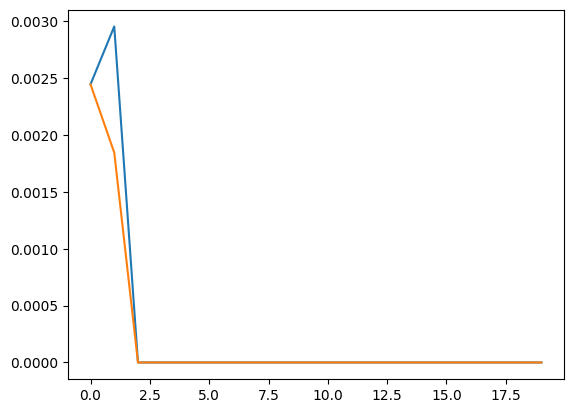

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad

# Given function definitions
def g_tau(tau, a, b, c, d):
    """eq 2, also the function for sigma_i(tau_i)"""
    val = (a + b * tau) * np.exp(-c * tau) + d
    return np.maximum(val, 1e-6)

def h_tau(tau, ah, bh, gamma, delta):
    """eq 19, also the function for nu_i(tau_i) (volatility of volatility)"""
    val = (ah + bh * tau) * np.exp(-gamma * tau) + delta
    return np.maximum(val, 1e-6)

# Integral of g^2 over [0, T]
def g_hat(T, a, b, c, d):
    integral, _ = quad(lambda tau: g_tau(tau, a, b, c, d) ** 2, 0, T)
    return np.sqrt(integral / T)

# Integral of h^2 over [0, T]
def h_hat(T, ah, bh, gamma, delta):
    integral, _ = quad(lambda tau: h_tau(tau, ah, bh, gamma, delta) ** 2, 0, T)
    return np.sqrt(integral / T)




def initial_vol(rho_arr, W_arr, k_0_arr, g_tau_arr, T):
    """
    Computes the initial volatility Σ₀ using equation (63).

    Parameters:
    - rho_arr: (numpy array) Correlation matrix ρ_ij of forward rates.
    - W_arr: (numpy array) Initial Brownian motion weights W_i^0.
    - k_0_arr: (numpy array) Initial volatility scaling factors k_0^i.
    - g_tau_arr: (numpy array) Instantaneous volatility function g^i over time.
    - T: (float) Maturity time T.

    Returns:
    - Σ₀: (float) The initial volatility term.
    """
    no_of_fwds = len(W_arr)
    
    # Compute the integral part ∫₀ᵀ g^i g^j dt
    integral_g = np.trapz(g_tau_arr @ g_tau_arr.T, dx=T / g_tau_arr.shape[1])
    
    # Compute the double sum term
    sum_term = 0
    for i in range(no_of_fwds):
        for j in range(no_of_fwds):
            sum_term += rho_arr[i, j] * W_arr[i] * W_arr[j] * k_0_arr[i] * k_0_arr[j] * integral_g[i, j]
    
    # Compute Σ₀
    Sigma_0 = np.sqrt((1 / T) * sum_term)
    
    return Sigma_0

initial_vol()

import numpy as np

def compute_V(Sigma_0, rho_arr, theta_arr, W_arr, k_0_arr, g_tau_arr, h_hat_tau_arr, T):
    """
    Computes V using the given formula.

    Parameters:
    - Sigma_0: (float) Initial volatility term Σ₀.
    - rho_arr: (numpy array) Correlation matrix ρ_ij of forward rates.
    - theta_arr: (numpy array) Additional correlation matrix θ_ij.
    - W_arr: (numpy array) Initial Brownian motion weights W_i^0.
    - k_0_arr: (numpy array) Initial volatility scaling factors k_0^i.
    - g_tau_arr: (numpy array) Instantaneous volatility function g^i over time.
    - h_hat_tau_arr: (numpy array) Function \( \hat{h}_{ij}(t) \) over time.
    - T: (float) Maturity time T.

    Returns:
    - V: (float) The computed volatility term V.
    """
    no_of_fwds = len(W_arr)
    
    # Compute the integral part ∫₀ᵀ g^i g^j (h_hat_ij(t))² t dt using trapezoidal rule
    t_grid = np.linspace(0, T, h_hat_tau_arr.shape[1])  # Time grid
    integral_h = np.trapz(g_tau_arr @ g_tau_arr.T * h_hat_tau_arr**2 * t_grid, dx=T / h_hat_tau_arr.shape[1])

    # Compute the double sum term
    sum_term = 0
    for i in range(no_of_fwds):
        for j in range(no_of_fwds):
            sum_term += 2 * rho_arr[i, j] * theta_arr[i, j] * W_arr[i] * W_arr[j] * k_0_arr[i] * k_0_arr[j] * integral_h[i, j]
    
    # Compute V
    V = (1 / (Sigma_0 * T)) * np.sqrt(sum_term)
    
    return V

import numpy as np

def compute_Omega(rho_mat, phi_mat, W_arr, k_0_arr, g_tau_arr, h_hat_tau_arr, V, Sigma_0, T):
    """
    Computes Ω_ij using equation (76).

    Parameters:
    - rho_mat: (numpy array) Correlation matrix ρ_ij of forward rates.
    - phi_mat: (numpy array) Correlation matrix φ_ij between forward rates and their volatilities.
    - W_arr: (numpy array) Initial Brownian motion weights W_i^0.
    - k_0_arr: (numpy array) Initial volatility scaling factors k_0^i.
    - g_tau_arr: (numpy array) Instantaneous volatility function g^i over time.
    - h_hat_tau_arr: (numpy array) Function \( \hat{h}_{ij}(t) \) over time.
    - V: (float) Computed volatility term from equation (previous).
    - Sigma_0: (float) Initial volatility term.
    - T: (float) Maturity time.

    Returns:
    - Omega_mat: (numpy array) Matrix of Ω_ij values.
    """
    no_of_fwds = len(W_arr)
    
    # Compute the integral part ∫₀ᵀ g^i g^j (h_hat_ij(t))² t dt using trapezoidal rule
    t_grid = np.linspace(0, T, h_hat_tau_arr.shape[1])  # Time grid
    integral_h = np.trapz(g_tau_arr @ g_tau_arr.T * h_hat_tau_arr**2 * t_grid, dx=T / h_hat_tau_arr.shape[1])

    # Compute Ω_ij matrix
    Omega_mat = np.zeros((no_of_fwds, no_of_fwds))
    denominator = (V * Sigma_0 * T) ** 2  # (V Σ₀ T)²
    
    for i in range(no_of_fwds):
        for j in range(no_of_fwds):
            numerator = 2 * rho_mat[i, j] * phi_mat[i, j] * W_arr[i] * W_arr[j] * k_0_arr[i] * k_0_arr[j] * integral_h[i, j]
            Omega_mat[i, j] = numerator / denominator
    
    return Omega_mat


import numpy as np

def compute_Phi(Omega_mat, phi_mat, atol=1e-6):
    """
    Computes Φ using equation (78) and verifies Ω_ij constraints.

    Parameters:
    - Omega_mat: (numpy array) Weighting matrix Ω_ij.
    - phi_mat: (numpy array) Correlation matrix φ_ij between forward rates and their volatilities.
    - atol: (float) Tolerance for floating-point comparisons (default: 1e-6).

    Returns:
    - Phi: (float) The computed Φ value.
    """
    # Check that Ω_ij >= 0
    if np.any(Omega_mat < -atol):  # Allow small numerical noise
        raise ValueError("Error: Some elements in Omega_mat are negative!")

    # Check that sum of Ω_ij is close to 1
    Omega_sum = np.sum(Omega_mat)
    if not np.isclose(Omega_sum, 1.0, atol=atol):
        raise ValueError(f"Error: Sum of Ω_ij is {Omega_sum}, expected 1.0")

    # Compute Φ as the weighted sum of Ω_ij * φ_ij
    Phi = np.sum(Omega_mat * phi_mat)
    
    return Phi

import numpy as np

def compute_B(w_arr, beta_arr, atol=1e-6):
    """
    Computes B using equation (79), ensuring w_k acts as valid weights.

    Parameters:
    - w_arr: (numpy array) Weight vector w_k, corresponding to the swap periods.
    - beta_arr: (numpy array) Corresponding beta values β_k for each period.
    - atol: (float) Tolerance for floating-point comparisons (default: 1e-6).

    Returns:
    - B: (float) The computed exponent B.
    """
    # Truncate arrays to match the running time of the swap
    w_arr = w_arr
    beta_arr = beta_arr

    # Ensure w_k are valid weights (sum to 1)
    w_sum = np.sum(w_arr)
    if not np.isclose(w_sum, 1.0, atol=atol):
        raise ValueError(f"Error: Sum of w_k is {w_sum}, expected 1.0")

    # Compute B as the weighted sum over the swap's running period
    B = np.sum(w_arr * beta_arr)
    
    return B

